In [1]:
# cnn_chachapoyas = tf.keras.models.load_model('saved_models/1dcnn_Chachapoyas_HIT')

# # Check its architecture
# cnn_chachapoyas.summary()

In [2]:
import pandas as pd
import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import darts
import math

In [3]:
# from tqdm.keras import TqdmCallback
# import tensorflow_addons as tfa
# from keras_tqdm import TQDMNotebookCallback

In [4]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [5]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.statistics import plot_acf
from darts.models.arima import ARIMA
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape

Importing plotly failed. Interactive plots will not work.


In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para alocar apenas a memória da GPU necessária para as alocações de tempo de execução
    tf.config.experimental.set_memory_growth(gpus[0], True) 
print(gpus)

[]


In [7]:
print(tf.__version__)
print(tf.keras.__version__)
import keras
print(keras.__version__)

2.1.0
2.2.4-tf
2.3.1


Using TensorFlow backend.


In [8]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from keras.layers import LSTM

In [9]:
root = r'/'
data_path = r'data/dibanez/tesis/data_preprocesada/2.llenada/'

In [10]:
!ls /{data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


# Preparación y Entrenamiento

## Lectura de datos

In [11]:
def print_df(df):
  print(df.shape)
  return df.head()

In [37]:
data_file = data_path+'llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv'

In [38]:
data_file_Juliaca = data_path+'llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv'

In [39]:
df = pd.read_csv(root+data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(3145, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-01-19 07:00:00,NaN,20.001276,126.680377,173.539583,1.064129,172.980513,134.00,185.970980
1,1,2021-01-19 08:00:00,NaN,25.182080,243.603396,174.955917,2.108640,351.380000,261.25,369.638333
2,2,2021-01-19 09:00:00,NaN,31.341689,326.799399,173.516750,2.794172,460.868333,472.50,483.831667
3,3,2021-01-19 10:00:00,NaN,39.362302,519.406319,172.040217,4.080710,666.266667,597.50,698.446667
4,4,2021-01-19 11:00:00,NaN,42.289113,621.082664,172.217183,4.839277,794.816667,435.00,832.055000


In [40]:
df.Fecha.min()

Timestamp('2021-01-19 07:00:00')

In [41]:
df_Juliaca = pd.read_csv(root+data_file_Juliaca, parse_dates=True)
df_Juliaca.Fecha = pd.to_datetime(df_Juliaca.Fecha)
df_Juliaca=df_Juliaca.reset_index()
print_df(df_Juliaca)

(2098, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-04-24 09:00:00,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.25,1275.976130
1,1,2021-04-24 10:00:00,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.75,1350.538889
2,2,2021-04-24 11:00:00,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.00,1426.380556
3,3,2021-04-24 12:00:00,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.00,1266.764674
4,4,2021-04-24 13:00:00,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.75,1162.694625


In [42]:
df_Juliaca.Fecha.min()

Timestamp('2021-04-24 09:00:00')

In [43]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    0.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

In [44]:
df_Juliaca.isna().sum()/len(df_Juliaca)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    1.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

## Codificación de fechas


In [45]:
start = df.iloc[0]['Fecha']
start

Timestamp('2021-01-19 07:00:00')

In [46]:
start_J = df_Juliaca.iloc[0]['Fecha']
start_J

Timestamp('2021-04-24 09:00:00')

In [47]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
df.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2021-01-19 07:00:00,NaN,20.001276,126.680377,173.539583,1.064129,172.980513,134.000000,185.970980,2021-01-19 07:00:00
1,1,2021-01-19 08:00:00,NaN,25.182080,243.603396,174.955917,2.108640,351.380000,261.250000,369.638333,2021-01-19 08:00:00
2,2,2021-01-19 09:00:00,NaN,31.341689,326.799399,173.516750,2.794172,460.868333,472.500000,483.831667,2021-01-19 09:00:00
3,3,2021-01-19 10:00:00,NaN,39.362302,519.406319,172.040217,4.080710,666.266667,597.500000,698.446667,2021-01-19 10:00:00
4,4,2021-01-19 11:00:00,NaN,42.289113,621.082664,172.217183,4.839277,794.816667,435.000000,832.055000,2021-01-19 11:00:00
5,5,2021-01-19 12:00:00,NaN,47.601484,791.262844,172.198683,5.652412,928.681667,287.250000,972.373333,2021-01-19 12:00:00
6,6,2021-01-19 13:00:00,NaN,41.764651,596.098252,172.173117,4.309573,706.826667,878.750000,739.996667,2021-01-19 13:00:00
7,7,2021-01-19 14:00:00,NaN,38.495504,575.606230,172.793800,4.299627,706.201667,664.500000,739.280000,2021-01-19 14:00:00
8,8,2021-01-19 15:00:00,NaN,36.718274,425.935810,172.185900,3.488035,571.151667,349.000000,598.205000,2021-01-19 15:00:00
9,9,2021-01-19 16:00:00,NaN,30.803783,268.995017,172.519667,2.277367,372.341667,141.250000,392.073333,2021-01-19 16:00:00


In [48]:
fechas_origen = df.Fecha

In [49]:
fechas_origen[:11+1]

0    2021-01-19 07:00:00
1    2021-01-19 08:00:00
2    2021-01-19 09:00:00
3    2021-01-19 10:00:00
4    2021-01-19 11:00:00
5    2021-01-19 12:00:00
6    2021-01-19 13:00:00
7    2021-01-19 14:00:00
8    2021-01-19 15:00:00
9    2021-01-19 16:00:00
10   2021-01-20 06:00:00
11   2021-01-20 07:00:00
Name: Fecha, dtype: datetime64[ns]

In [50]:
df_Juliaca['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df_Juliaca))
df_Juliaca.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2021-04-24 09:00:00,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.250000,1275.976130,2021-01-19 07:00:00
1,1,2021-04-24 10:00:00,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.750000,1350.538889,2021-01-19 08:00:00
2,2,2021-04-24 11:00:00,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.000000,1426.380556,2021-01-19 09:00:00
3,3,2021-04-24 12:00:00,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.000000,1266.764674,2021-01-19 10:00:00
4,4,2021-04-24 13:00:00,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.750000,1162.694625,2021-01-19 11:00:00
5,5,2021-04-24 14:00:00,NaN,44.038333,NaN,169.331291,5.566609,900.614855,1234.000000,939.059420,2021-01-19 12:00:00
6,6,2021-04-24 15:00:00,NaN,35.627288,NaN,173.885889,3.162108,526.405556,896.000000,550.208333,2021-01-19 13:00:00
7,7,2021-04-24 16:00:00,NaN,20.452167,NaN,172.374389,1.229011,212.008333,343.750000,222.190196,2021-01-19 14:00:00
8,8,2021-04-25 06:00:00,NaN,2.292203,NaN,190.279310,1.225845,224.982759,220.105263,235.842105,2021-01-19 15:00:00
9,9,2021-04-25 07:00:00,NaN,18.341695,NaN,182.686500,3.773683,657.466667,655.000000,686.383333,2021-01-19 16:00:00


In [51]:
fechas_origen_Target = df_Juliaca.Fecha

In [52]:
fechas_origen_Target[:11+1]

0    2021-04-24 09:00:00
1    2021-04-24 10:00:00
2    2021-04-24 11:00:00
3    2021-04-24 12:00:00
4    2021-04-24 13:00:00
5    2021-04-24 14:00:00
6    2021-04-24 15:00:00
7    2021-04-24 16:00:00
8    2021-04-25 06:00:00
9    2021-04-25 07:00:00
10   2021-04-25 08:00:00
11   2021-04-25 09:00:00
Name: Fecha, dtype: datetime64[ns]

## Preprocesamiento

In [53]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tmod'])#,'Irradiancia'])#, freq='H')
type(series_raw)

darts.timeseries.TimeSeries

In [54]:
col_obj = 'Pac'

In [55]:
series_raw[col_obj]

                             Pac
Fecha_cod                       
2021-01-19 07:00:00   134.000000
2021-01-19 08:00:00   261.250000
2021-01-19 09:00:00   472.500000
2021-01-19 10:00:00   597.500000
2021-01-19 11:00:00   435.000000
...                          ...
2021-05-30 03:00:00  1390.950000
2021-05-30 04:00:00  1396.250000
2021-05-30 05:00:00  1075.650000
2021-05-30 06:00:00   543.900000
2021-05-30 07:00:00   285.673913

[3145 rows x 1 columns]
Freq: H

In [56]:
series_raw[col_obj][:12]

                            Pac
Fecha_cod                      
2021-01-19 07:00:00  134.000000
2021-01-19 08:00:00  261.250000
2021-01-19 09:00:00  472.500000
2021-01-19 10:00:00  597.500000
2021-01-19 11:00:00  435.000000
2021-01-19 12:00:00  287.250000
2021-01-19 13:00:00  878.750000
2021-01-19 14:00:00  664.500000
2021-01-19 15:00:00  349.000000
2021-01-19 16:00:00  141.250000
2021-01-19 17:00:00   59.821207
2021-01-19 18:00:00  166.397523
Freq: H

In [57]:
len(series_raw)

3145

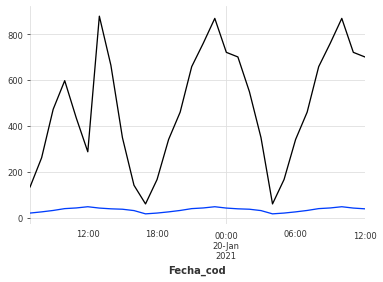

In [58]:
series_raw[0:30].plot()

In [59]:
series_raw_Target = TimeSeries.from_dataframe(df_Juliaca, 'Fecha_cod', ['Pac','Tmod'])#,'Irradiancia'])#, freq='H')
type(series_raw_Target)

darts.timeseries.TimeSeries

In [60]:
col_obj = 'Pac'

In [61]:
series_raw_Target[col_obj]

                         Pac
Fecha_cod                   
2021-01-19 07:00:00   696.25
2021-01-19 08:00:00  1387.75
2021-01-19 09:00:00  1149.00
2021-01-19 10:00:00  1462.00
2021-01-19 11:00:00  1420.75
...                      ...
2021-04-16 12:00:00  1416.25
2021-04-16 13:00:00   738.50
2021-04-16 14:00:00   362.25
2021-04-16 15:00:00   177.50
2021-04-16 16:00:00   232.75

[2098 rows x 1 columns]
Freq: H

In [62]:
series_raw_Target[col_obj][:12]

                             Pac
Fecha_cod                       
2021-01-19 07:00:00   696.250000
2021-01-19 08:00:00  1387.750000
2021-01-19 09:00:00  1149.000000
2021-01-19 10:00:00  1462.000000
2021-01-19 11:00:00  1420.750000
2021-01-19 12:00:00  1234.000000
2021-01-19 13:00:00   896.000000
2021-01-19 14:00:00   343.750000
2021-01-19 15:00:00   220.105263
2021-01-19 16:00:00   655.000000
2021-01-19 17:00:00  1016.450000
2021-01-19 18:00:00  1283.750000
Freq: H

In [63]:
len(series_raw_Target)

2098

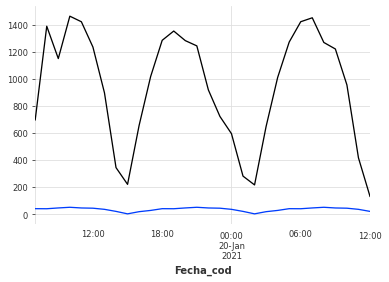

In [64]:
series_raw_Target[0:30].plot()

### Imputación de datos faltantes

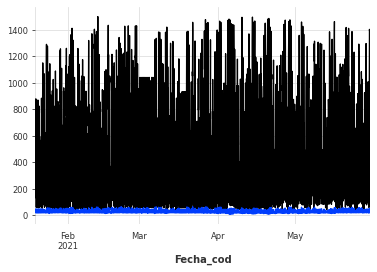

In [65]:
series_raw.plot()

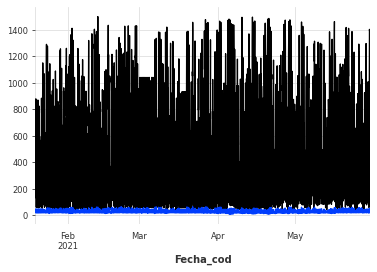

In [66]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

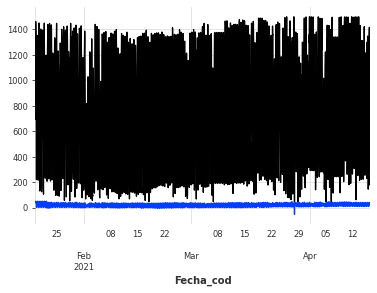

In [67]:
series_raw_Target.plot()

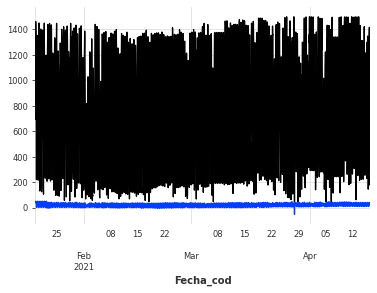

In [68]:
# TODO
filler = MissingValuesFiller()
series_Target = filler.transform(series_raw_Target, method='linear')
series_Target.plot()

### Separación de conjuntos de entrenamiento y validación

In [69]:
train_perc = .8
math.ceil(len(series)*train_perc)

2516

In [70]:
val_len = int(len(series)*(1-train_perc))

In [71]:
val_len -= val_len%11

In [72]:
val_len

627

In [73]:
train, val = series[:-val_len], series[-val_len:]

In [74]:
train

                             Pac       Tmod
Fecha_cod                                  
2021-01-19 07:00:00   134.000000  20.001276
2021-01-19 08:00:00   261.250000  25.182080
2021-01-19 09:00:00   472.500000  31.341689
2021-01-19 10:00:00   597.500000  39.362302
2021-01-19 11:00:00   435.000000  42.289113
...                          ...        ...
2021-05-04 00:00:00  1426.500000  50.348833
2021-05-04 01:00:00   950.433333  44.599000
2021-05-04 02:00:00   744.783333  39.878448
2021-05-04 03:00:00   929.833333  40.760690
2021-05-04 04:00:00   329.766667  30.554068

[2518 rows x 2 columns]
Freq: H

In [75]:
train_perc = .8
math.ceil(len(series_Target)*train_perc)

1679

In [76]:
val_len = int(len(series_Target)*(1-train_perc))

In [77]:
val_len -= val_len%11

In [78]:
val_len

418

In [79]:
train_Target, val_Target = series[:-val_len], series[-val_len:]

In [80]:
train_Target

                            Pac       Tmod
Fecha_cod                                 
2021-01-19 07:00:00  134.000000  20.001276
2021-01-19 08:00:00  261.250000  25.182080
2021-01-19 09:00:00  472.500000  31.341689
2021-01-19 10:00:00  597.500000  39.362302
2021-01-19 11:00:00  435.000000  42.289113
...                         ...        ...
2021-05-12 17:00:00  885.850000  35.982000
2021-05-12 18:00:00  801.066667  32.233167
2021-05-12 19:00:00  669.083333  32.808500
2021-05-12 20:00:00  315.183333  26.518983
2021-05-12 21:00:00  265.316667  25.128000

[2727 rows x 2 columns]
Freq: H

In [81]:
# plot_acf(train)

## Visualización

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

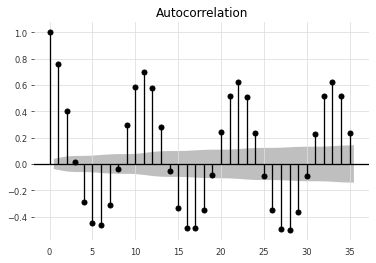

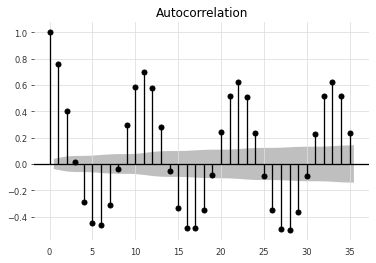

In [83]:
plot_acf(train[col_obj].values())

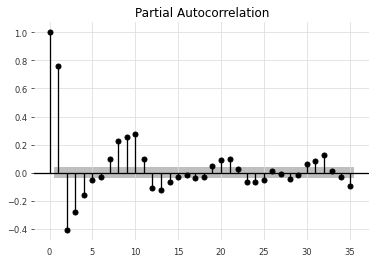

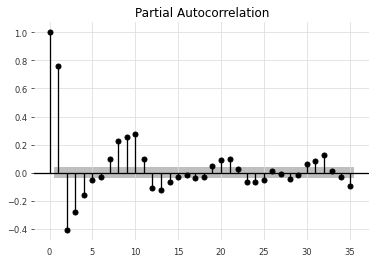

In [84]:
plot_pacf(train[col_obj].values())

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

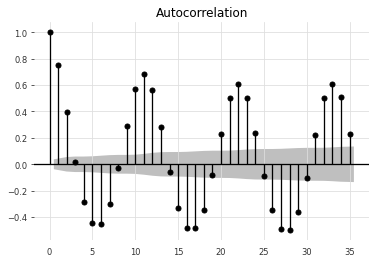

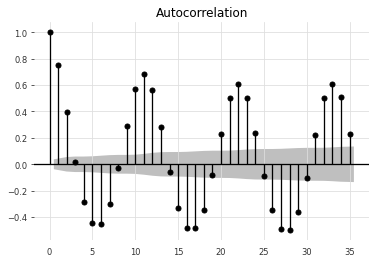

In [86]:
plot_acf(train_Target[col_obj].values())

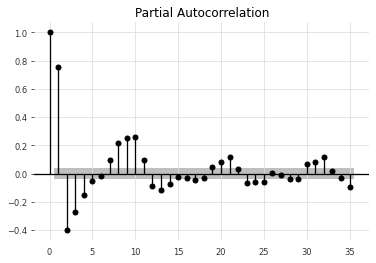

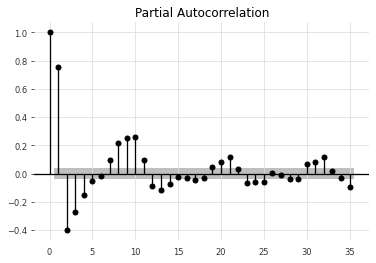

In [87]:
plot_pacf(train_Target[col_obj].values())

## Training (CNN)

In [103]:
df_columns = ['Pac', 'Tmod']#,'Irradiancia']

In [104]:
arr_train_Target = train_Target.values()
arr_train_Target

array([[134.        ,  20.00127607],
       [261.25      ,  25.18207958],
       [472.5       ,  31.34168927],
       ...,
       [669.08333333,  32.8085    ],
       [315.18333333,  26.51898305],
       [265.31666667,  25.128     ]])

In [105]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [106]:
n_steps_in, n_steps_out = 11, 11
X_Target, y_Target = split_sequences(arr_train_Target, n_steps_in, n_steps_out)
print(X_Target.shape, y_Target.shape)

(2706, 11, 2) (2706, 11)


In [107]:
print(X_Target[0], y_Target[0])

[[134.          20.00127607]
 [261.25        25.18207958]
 [472.5         31.34168927]
 [597.5         39.36230197]
 [435.          42.2891135 ]
 [287.25        47.60148358]
 [878.75        41.76465093]
 [664.5         38.49550444]
 [349.          36.71827441]
 [141.25        30.80378347]
 [ 59.82120664  16.55157143]] [166.39752275 341.03181818 460.20909091 658.62121212 760.58636364
 869.06212121 720.98181818 700.93636364 549.27121212 349.36515152
  59.82120664]


In [108]:
X_Target.shape

(2706, 11, 2)

In [109]:
y_Target.shape

(2706, 11)

### Transfer learning from Chachapoyas to Juliaca

In [110]:
cnn_chachapoyas = tf.keras.models.load_model('saved_models/1dcnn_Chachapoyas_HIT')

# Check its architecture
cnn_chachapoyas.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [111]:
cnn_chachapoyas.layers

In [112]:
# Freeze weights
cnn_chachapoyas.layers[0].trainable = False

In [113]:
cnn_chachapoyas.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 17,251
Trainable params: 16,931
Non-trainable params: 320
_________________________________________________________________


In [114]:
chachapoyas_original_weights_values = cnn_chachapoyas.get_weights()


In [115]:
cnn_chachapoyas.compile(optimizer='adam', loss='mse')


In [117]:
%%time
hist_cnn_transfer = cnn_chachapoyas.fit(X_Target, y_Target, epochs=3500, verbose=1)

Train on 2706 samples
Epoch 1/3500
2706/2706 [==============================] - 0s 148us/sample - loss: 54818.0894
Epoch 2/3500
2706/2706 [==============================] - 0s 91us/sample - loss: 51030.6045
Epoch 3/3500
2706/2706 [==============================] - 0s 91us/sample - loss: 49031.0303
Epoch 4/3500
2706/2706 [==============================] - 0s 90us/sample - loss: 47973.4489
Epoch 5/3500
2706/2706 [==============================] - 0s 91us/sample - loss: 47016.1422
Epoch 6/3500
2706/2706 [==============================] - 0s 90us/sample - loss: 46415.0365
Epoch 7/3500
2706/2706 [==============================] - 0s 89us/sample - loss: 45784.9083
Epoch 8/3500
2706/2706 [==============================] - 0s 89us/sample - loss: 45694.7344
Epoch 9/3500
2706/2706 [==============================] - 0s 91us/sample - loss: 44614.1570
Epoch 10/3500
2706/2706 [==============================] - 0s 91us/sample - loss: 44519.3431
Epoch 11/3500
2706/2706 [==============================]

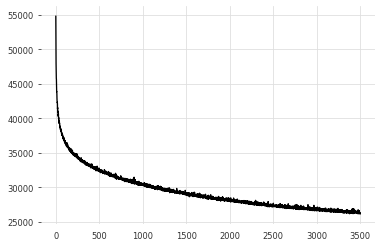

In [118]:
plt.plot(hist_cnn_transfer.history['loss'])

In [119]:
cnn_juliaca_transfered = cnn_chachapoyas
cnn_juliaca_transfered.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,611
Non-trainable params: 320
_________________________________________________________________


In [121]:
# 1dcnn_Chachapoyas_PERC

In [122]:
cnn_chachoyas_to_juliaca = cnn_juliaca_transfered
cnn_chachoyas_to_juliaca.save('saved_models/1dcnn_Chachapoyas_to_Juliaca_PERC') #Pac, Tamb

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/1dcnn_Chachapoyas_to_Juliaca_PERC/assets


### Sin transferencia

In [125]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X_Target.shape[2]   


# define el modelo
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
modelo_cnn.add(MaxPooling1D(pool_size=2))
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(50, activation='relu'))
modelo_cnn.add(Dense(n_steps_out))
modelo_cnn.compile(optimizer='adam', loss='mse')

# entrena el modelo Vector-Output Mulkti-step MLP con la la data de entrenamiento generada
hist_cnn = modelo_cnn.fit(X_Target, y_Target, epochs=3500, verbose=1)#, callbacks=[TqdmCallback(verbose=2)])




Epoch 1/3500
2706/2706 [==============================] - 0s 115us/step - loss: 182626.4909
Epoch 2/3500
2706/2706 [==============================] - 0s 101us/step - loss: 77548.8881
Epoch 3/3500
2706/2706 [==============================] - 0s 101us/step - loss: 74342.9565
Epoch 4/3500
2706/2706 [==============================] - 0s 100us/step - loss: 72865.9885
Epoch 5/3500
2706/2706 [==============================] - 0s 100us/step - loss: 71735.2134
Epoch 6/3500
2706/2706 [==============================] - 0s 99us/step - loss: 70781.7248
Epoch 7/3500
2706/2706 [==============================] - 0s 98us/step - loss: 70242.9070
Epoch 8/3500
2706/2706 [==============================] - 0s 100us/step - loss: 69179.6908
Epoch 9/3500
2706/2706 [==============================] - 0s 98us/step - loss: 68548.2783
Epoch 10/3500
2706/2706 [==============================] - 0s 99us/step - loss: 67868.9662
Epoch 11/3500
2706/2706 [==============================] - 0s 99us/step - loss: 67064.2702
E

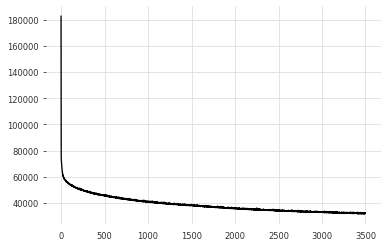

In [126]:
plt.plot(hist_cnn.history['loss'])

In [127]:
cnn_juliaca_sin_transferencia = modelo_cnn

In [128]:
# muestra un resumen de la topologia del modelo
cnn_juliaca_sin_transferencia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [129]:
# modelo_cnn = modelo

In [130]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 11ms/step


array([[  93.2883 ,  242.4135 ,  539.4217 ,  881.3142 , 1077.6498 ,
        1052.9318 ,  931.2309 ,  776.1418 ,  624.8219 ,  415.9727 ,
         205.31598]], dtype=float32)

In [131]:
# modelo_cnn.save('saved_models/1dcnn_Chachapoyas_PERC') #Pac, Tmod

In [132]:
# cnn_chachoyas_to_juliaca = cnn_juliaca_transfered
cnn_juliaca_sin_transferencia.save('saved_models/1dcnn_Juliaca_PERC') #Pac, Tmod

# Comparación de modelos

#### Walk forward para modelos neuronales

In [133]:
def walk_forward_evaluation_neuronal(train, val, model, n_pred, col_obj, es_neuronal=True):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    x_input = train[-11:]
    if es_neuronal:
        pass #model.fit(train)
    
    arr_pred=None
    arr_real=None 
    for t in range(val.shape[0]-n_pred):
        if (t%100 == 0) or (t == (val.shape[0]-n_pred-1)):
            print(f't={t}/{val.shape[0]-n_pred-1}')
            print(f'history len = {x_input.shape[0]}')
            print()
        
        #valores predichos
        if not es_neuronal:
#             model.fit(history[col_obj])
            pred = model.predict(n_pred)
        else:
            pred = model.predict(x_input.reshape((1, 11, train.shape[1])) )
            
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
            
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        if not es_neuronal:
            real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        else:
            real = val[t:t+n_pred,0].reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        x_input = np.vstack((x_input[1:],val[t]))
    
    return arr_pred, arr_real
    

NameError: name 'n_predict' is not defined

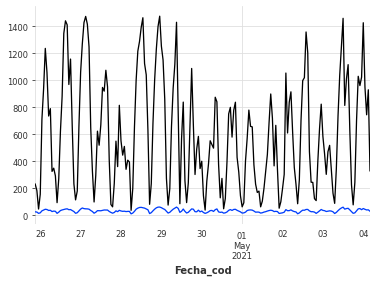

In [134]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

## Modelo transferido (Origen: Chachapoyas, Destino: Juliaca)

In [135]:
cnn_juliaca_transfered.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,611
Non-trainable params: 320
_________________________________________________________________


In [136]:
x_input = train_Target[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = cnn_juliaca_transfered.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 29ms/sample


array([[123.96837, 216.56856, 433.03516, 639.21075, 791.786  , 872.4145 ,
        861.6213 , 763.1386 , 638.6776 , 411.10632, 195.59389]],
      dtype=float32)

In [137]:
# from sklearn.metrics import r2_score
# real_Target = val_Target[:8].values()[:,0]

### Walk Forward CNN

In [168]:
model = cnn_juliaca_transfered
n_pred = 11
val_wfe = val_Target.values()[:n_pred*12]#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train_Target.values()
print(len(train_wfe))
print(len(val_wfe))

2727
132


In [169]:
n_features

2

In [170]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/120
history len = 11

t=100/120
history len = 11

t=120/120
history len = 11

CPU times: user 2.42 s, sys: 0 ns, total: 2.42 s
Wall time: 2.27 s


In [171]:
# arr_pred

In [172]:
# arr_real

#### Metric Evaluation CNN

In [173]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [174]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([234.30142678, 271.36463343, 281.70542946, 298.32033122,
       296.968301  , 304.58689547, 325.83016198, 320.15801237,
       359.37862998, 334.91816078, 330.81006189])

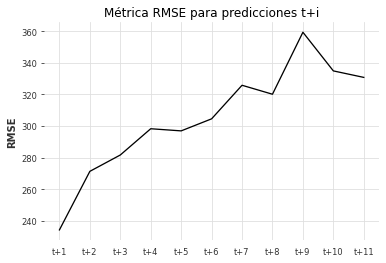

In [175]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [176]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.51905944, 0.39489098, 0.37039533, 0.317675  , 0.25199977,
       0.17572085, 0.16148865, 0.29005276, 0.14962595, 0.2190069 ,
       0.16105823])

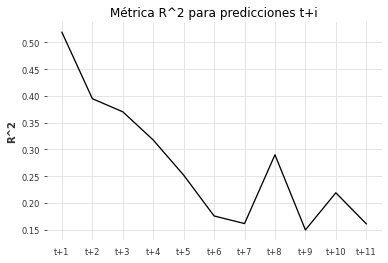

In [177]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

## Modelo no transferido (Entrenado: Juliaca, Probado: Juliaca)

In [178]:
cnn_juliaca_sin_transferencia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [179]:
x_input = train_Target[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = cnn_juliaca_sin_transferencia.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[155.82158, 302.7741 , 499.3065 , 714.399  , 853.43256, 918.39026,
        964.5582 , 905.7106 , 704.5006 , 451.9864 , 205.02167]],
      dtype=float32)

In [180]:
# from sklearn.metrics import r2_score
# real_Target = val_Target[:8].values()[:,0]

### Walk Forward CNN

In [181]:
model = cnn_juliaca_sin_transferencia
n_pred = 11
val_wfe = val_Target.values()#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train_Target.values()
print(len(train_wfe))
print(len(val_wfe))

2727
418


In [182]:
n_features

2

In [183]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/406
history len = 11

t=100/406
history len = 11

t=200/406
history len = 11

t=300/406
history len = 11

t=400/406
history len = 11

t=406/406
history len = 11

CPU times: user 633 ms, sys: 91.8 ms, total: 725 ms
Wall time: 461 ms


In [184]:
# arr_pred

In [185]:
# arr_real

#### Metric Evaluation CNN

In [186]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [187]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([225.08532936, 254.75281424, 276.49426161, 290.54391632,
       301.40232443, 300.12559525, 320.03472571, 315.39291645,
       312.79860992, 323.92672951, 310.66618344])

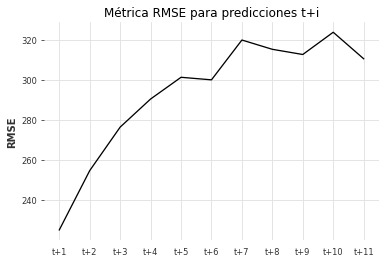

In [188]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [189]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 0.47765861,  0.2717911 ,  0.15490479,  0.07371909,  0.01792809,
        0.06168867, -0.00791621,  0.04081854,  0.0618363 , -0.05907308,
       -0.04526546])

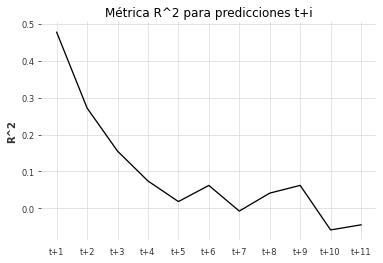

In [190]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

## Modelo no transferido (Entrenado: Chachapoyas, Probado: Juliaca)


In [191]:
cnn_chachapoyas = tf.keras.models.load_model('saved_models/1dcnn_Chachapoyas_HIT')

# Check its architecture
cnn_chachapoyas.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [192]:
x_input = train_Target[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = cnn_chachapoyas.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 48ms/sample


array([[188.86708, 290.3341 , 450.26984, 631.219  , 798.2157 , 917.1072 ,
        987.7702 , 935.04126, 823.98785, 631.15094, 397.58096]],
      dtype=float32)

In [193]:
# from sklearn.metrics import r2_score
# real_Target = val_Target[:8].values()[:,0]

### Walk Forward CNN

In [194]:
model = cnn_chachapoyas
n_pred = 11
val_wfe = val_Target.values()[:n_pred*5] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train_Target.values()
print(len(train_wfe))
print(len(val_wfe))

2727
55


In [195]:
n_features

2

In [196]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/43
history len = 11

t=43/43
history len = 11

CPU times: user 865 ms, sys: 31.7 ms, total: 896 ms
Wall time: 824 ms


In [197]:
# arr_pred

In [198]:
# arr_real

#### Metric Evaluation CNN

In [199]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [200]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([206.1101316 , 241.60064303, 340.37467979, 347.03684567,
       354.08805906, 320.81886706, 322.39576473, 341.02305805,
       352.40357791, 347.4152152 , 352.74719031])

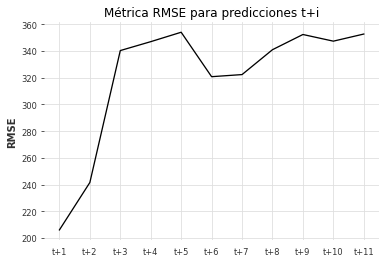

In [201]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [202]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 0.60900997,  0.53215271,  0.12197381,  0.11404413, -0.06253501,
        0.00517935,  0.12873022,  0.22106043,  0.2366404 ,  0.1843167 ,
       -0.00457632])

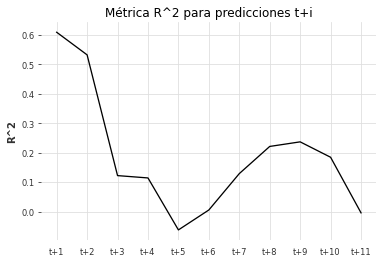

In [203]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Comapración de Análisis Walk Forward

In [204]:
import numpy as np

In [205]:
rmse_transferido = np.array([235.5189278 , 290.44505257, 308.69235627, 309.99218079,
       326.31692472, 356.96152391, 352.45566035, 352.69764556,
       359.47382002, 342.07472027, 350.25860383])
rmse_destino = np.array([237.61066408, 288.28075528, 318.35058314, 336.18365052,
       343.35802673, 346.53531638, 346.10941725, 335.42657674,
       341.15598482, 324.14874177, 316.29742972])
rmse_origen = np.array([220.62522595, 241.58038245, 296.88698565, 276.81460412,
       308.71838897, 321.09538694, 346.12932571, 383.96808215,
       397.00924874, 366.13368191, 341.4683715 ])
# rmse_lstm = np.array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
#        274.55980543, 231.67606308, 221.54597819, 211.42255549,
#        184.07502815, 164.89740173, 124.90828435])
ls_rmse = [  rmse_transferido,rmse_destino,rmse_origen]#,rmse_baseline]

In [206]:
r2_transferido = np.array([0.56706532, 0.37036132, 0.26614721, 0.28531707, 0.25277735,
       0.15197849, 0.23231686, 0.2451152 , 0.21994649, 0.20802081,
       0.05263241])
r2_destino = np.array([0.48942614, 0.26512935, 0.17135514, 0.11397882, 0.08935542,
       0.07963323, 0.10190587, 0.17677817, 0.11263308, 0.20035743,
       0.1242333 ])
r2_origen = np.array([ 0.53393568,  0.46806601,  0.12806032,  0.17648451, -0.13275727,
       -0.15723903,  0.01477522,  0.11876784,  0.14526692,  0.17336888,
        0.14920549])
# r2_lstm = np.array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
#        0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
#        0.97196451])
ls_r2 = [ r2_transferido, r2_destino,r2_origen]#,r2_baseline]

In [207]:
nombres_modelos = [ 'Modelo transferido', 'Modelo entrenado en destino', 'Modelo entrenado en origen']

#### Comparación de métrica RMSE 

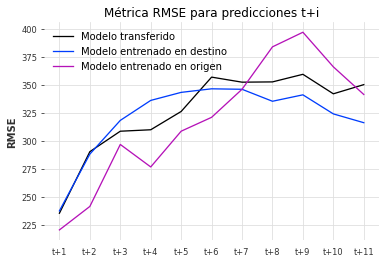

In [208]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()

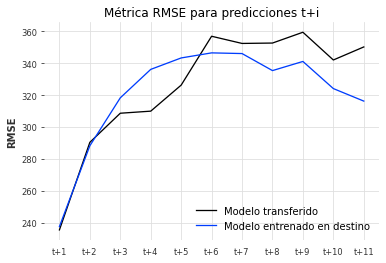

In [209]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse[:-1]:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos[:-1])
plt.show()

#### Comparación de métrica R^2

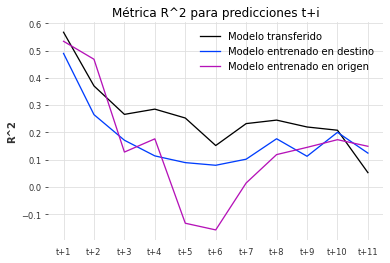

In [210]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
for ls_metric_t in ls_r2:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()